In [1]:
.L ../libAmBe.so

In [2]:
test // Check if lib is loaded correcly

(const int) 11


In [3]:
char const* path {"../dataset/AmBe_x1-y1_Run_99.root"};
DataSetHolder dataset = ambeDataSet(path);

In [4]:
double totalEvent = dataset.df.Count().GetValue();
totalEvent

(double) 139586.00


In [5]:
ROOT::RDF::RNode df = filterT1Events(dataset.df, 10e-6).Filter("is_event", "T1 Filter");

# First cut
4.44 gamma event created

In [6]:
double T1Event = df.Count().GetValue();
T1Event

(double) 86297.000


In [7]:
 T1Event * 100. / totalEvent

(double) 61.823535


# Second cut
Gamma 4.44 reach detector && CE e^- above 4 MeV reach the detector

In [8]:
ROOT::RDF::RNode df2 = df.Define("chainMaskT9", "decayChainMask(T9.parentid, T9.trackid, T9.pdg, T9.CreatorProcessID, T9.initialEkin)");
df2 = createT5Mask(df2);

In [9]:
df2 = df2.Filter("ROOT::VecOps::Any(chainMaskT5 == maskGAMMA)", "Gamma reach pvt")
    .Filter("ROOT::VecOps::Any(chainMaskT5 == maskCE_ELECT)", "CE reach pvt");

In [10]:
double T5Event = df2.Count().GetValue();
T5Event

(double) 18797.000


In [11]:
 T5Event * 100. / totalEvent

(double) 13.466250


In [12]:
df2 = df2.Filter("ROOT::VecOps::Any(T9.initialEkin[chainMaskT9 == maskCE_ELECT] > 4)", "CE produced with Ekin > 4");

In [13]:
double T5Event = df2.Count().GetValue();
T5Event

(double) 4595.0000


In [14]:
 T5Event * 100. / totalEvent

(double) 3.2918774


# Third and fourth cut
Gamma event inside only one cube && CE event inside only one cube

For a given Gap

In [15]:
ROOT::RDF::RNode df3 = df2.Define("volidCE", "volidEpvtTot(volid[chainMaskT5 == maskCE_ELECT || chainMaskT5 == maskCE_CHILD], edep_pvt[chainMaskT5 == maskCE_ELECT || chainMaskT5 == maskCE_CHILD])");
df3 = df3.Define("edep_pvtCE", "std::get<1>(volidCE)");
df3 = df3.Redefine("volidCE", "std::get<0>(volidCE)");
df3 = df3.Define("volidGamma", "volidEpvtTot(volid[chainMaskT5 == maskGAMMA || chainMaskT5 == maskG_CHILD], edep_pvt[chainMaskT5 == maskGAMMA || chainMaskT5 == maskG_CHILD])");
df3 = df3.Define("edep_pvtGamma", "std::get<1>(volidGamma)");
df3 = df3.Redefine("volidGamma", "std::get<0>(volidGamma)");

In [16]:
df3  = df3.Filter("ROOT::VecOps::Sum(edep_pvtGamma > 0.1) == 1", "1 cube Gamma")
    .Filter("ROOT::VecOps::Sum(edep_pvtCE > 0.1) == 1", "1 cube CE");

In [17]:
double GammaCEEvent = df3.Count().GetValue();
GammaCEEvent

(double) 1795.0000


In [18]:
 GammaCEEvent * 100. / totalEvent

(double) 1.2859456


# Cut five

Gamma <-> CE distance above 1

In [19]:
ROOT::RDF::RNode df4 = df3.Define("GammaEpvtRef", "edep_pvtGamma[edep_pvtGamma > 0.1]");
df4 = df4.Define("GammaVolidRef", "volidGamma[edep_pvtGamma > 0.1]");
df4 = df4.Define("CEEpvtRef", "edep_pvtCE[edep_pvtCE > 0.1]");
df4 = df4.Define("CEVolidRef", "volidCE[edep_pvtCE > 0.1]");

In [20]:
df4 = df4.Define("euclidDistGrefCeref", "euclidDist(CEVolidRef.at(0), GammaVolidRef)");
df4 = df4.Define("zDistGrefCeref", "zDist(CEVolidRef.at(0), GammaVolidRef)");

In [21]:
df4 = df4.Filter("ROOT::VecOps::Any(euclidDistGrefCeref >= 1.)", "Distance >= 1");

In [22]:
double TriggerEvent = df4.Count().GetValue();
TriggerEvent

(double) 1574.0000


In [23]:
TriggerEvent * 100. / totalEvent

(double) 1.1276202


# Noise cut

In [24]:
ROOT::RDF::RNode df5 = df4.Define("volidNeutron", "volidEpvtTot(volid[chainMaskT5 == maskNOISE], edep_pvt[chainMaskT5 == maskNOISE])");
df5 = df5.Define("edep_pvtNeutron", "std::get<1>(volidNeutron)");
df5 = df5.Redefine("volidNeutron", "std::get<0>(volidNeutron)");

In [25]:
df5 = df5.Define("edep_pvtNeutronCut", "edep_pvtNeutron[edep_pvtNeutron < 10000. && edep_pvtNeutron > 0.1]");
df5 = df5.Define("volidNeutronCut", "volidNeutron[edep_pvtNeutron < 100000. && edep_pvtNeutron > 0.1]");

In [26]:
df5 = df5.Define("CubeCounter", "volidNeutronCut.size()");

In [27]:
df5 = df5.Filter("!CubeCounter");

In [28]:
double WithoutNoiseEvent = df5.Count().GetValue()

(double) 235.00000


In [29]:
WithoutNoiseEvent * 100. / totalEvent

(double) 0.16835499


# Energy distributions

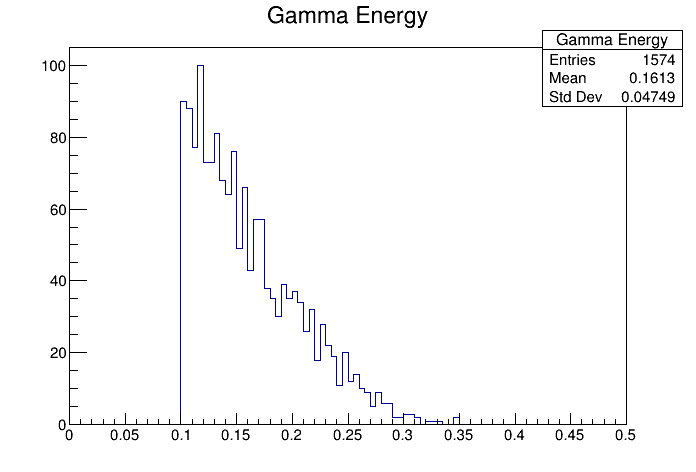

Info in <TCanvas::Print>: pdf file ../plots/pdf/GammaEnergydist.pdf has been created
Info in <TCanvas::Print>: ps file ../plots/pgf/GammaEnergydist.pgf has been created
Info in <TCanvas::Print>: png file ../plots/png/GammaEnergydist.png has been created


In [30]:
TCanvas c;
auto hist = df4.Histo1D({"Gamma Energy", "Gamma Energy", 100u, 0., 0.5}, "GammaEpvtRef")->DrawClone();
c.Draw();
std::string dir {"../plots"};
std::string file {"GammaEnergydist"};
savePlot(hist, dir, file);

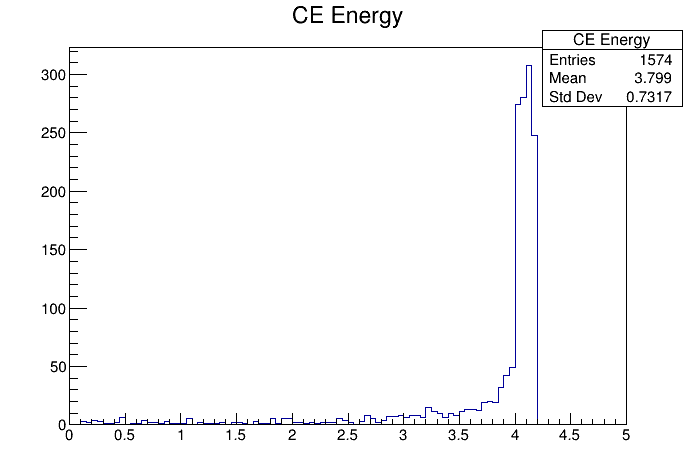

Info in <TCanvas::Print>: pdf file ../plots/pdf/CEEnergydist.pdf has been created
Info in <TCanvas::Print>: ps file ../plots/pgf/CEEnergydist.pgf has been created
Info in <TCanvas::Print>: png file ../plots/png/CEEnergydist.png has been created


In [31]:
TCanvas c;
auto hist = df4.Histo1D({"CE Energy", "CE Energy", 100u, 0., 5.0}, "CEEpvtRef")->DrawClone();
c.Draw();
std::string file {"CEEnergydist"};
savePlot(hist, dir, file);

# Distance CE Gamma

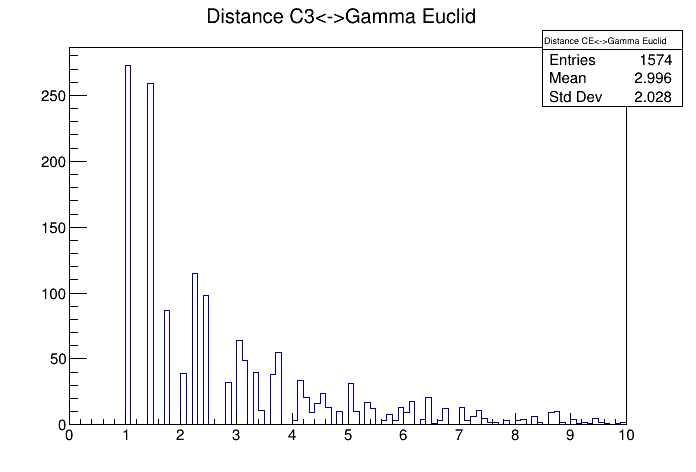

Info in <TCanvas::Print>: pdf file ../plots/pdf/GammaCEDistEuclid.pdf has been created
Info in <TCanvas::Print>: ps file ../plots/pgf/GammaCEDistEuclid.pgf has been created
Info in <TCanvas::Print>: png file ../plots/png/GammaCEDistEuclid.png has been created


In [32]:
TCanvas c;
auto hist = df4.Histo1D({"Distance CE<->Gamma Euclid", "Distance C3<->Gamma Euclid", 100u, 0., 10.}, "euclidDistGrefCeref")->DrawClone();
c.Draw();
std::string file {"GammaCEDistEuclid"};
savePlot(hist, dir, file);

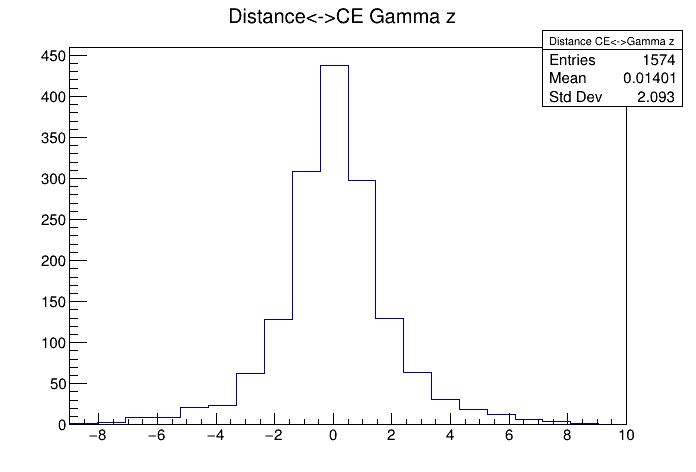

Info in <TCanvas::Print>: pdf file ../plots/pdf/GammaCEDistZ.pdf has been created
Info in <TCanvas::Print>: ps file ../plots/pgf/GammaCEDistZ.pgf has been created
Info in <TCanvas::Print>: png file ../plots/png/GammaCEDistZ.png has been created


In [33]:
TCanvas c;
auto hist = df4.Histo1D({"Distance CE<->Gamma z", "Distance<->CE Gamma z", 20u, -9., 10.}, "zDistGrefCeref")->DrawClone();
c.Draw();
std::string file {"GammaCEDistZ"};
savePlot(hist, dir, file);

In [34]:
// ROOT::RDF::SaveGraph(df4, "./firstFilterCutTree.dot");